## Import modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import session_info
session_info.show()

## Read in Visium sample table

In [3]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/metadata/HeartTeamSamples_Mappeddata_20221213.csv')
meta=meta[['Publication','sangerID', 'combinedID',
       'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender',
       'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed']]
meta=meta[meta['modality'].isin(['Visium','Visium-FFPE'])]

# select slides for 8regions publication
meta=meta[meta['Publication'].isin(['8regions','8regions_revision'])]

# change region
meta.loc[meta.index[meta['modality']=='Visium-FFPE'],'region']='SAN-FFPE'
meta = meta.sort_values(['Publication','sangerID'])
meta

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed
4,8regions,HCAHeartST10238250,na,D8,DCD,LV,LV,45-50,Male,Sanger,na,Visium,Visium-v1,no
5,8regions,HCAHeartST10238251,na,D8,DCD,RA,RA,45-50,Male,Sanger,na,Visium,Visium-v1,no
6,8regions,HCAHeartST10238252,na,D8,DCD,LA,LA,45-50,Male,Sanger,na,Visium,Visium-v1,no
7,8regions,HCAHeartST10238253,na,D8,DCD,AX,AX,45-50,Male,Sanger,na,Visium,Visium-v1,no
27,8regions,HCAHeartST10550729,na,D3,DBD,LV,LV,55-60,Male,Sanger,na,Visium,Visium-v1,no
28,8regions,HCAHeartST10550730,na,D3,DBD,RV,RV,55-60,Male,Sanger,na,Visium,Visium-v1,no
29,8regions,HCAHeartST10550731,na,D3,DBD,LA,LA,55-60,Male,Sanger,na,Visium,Visium-v1,no
30,8regions,HCAHeartST10550732,na,D3,DBD,SP,SP,55-60,Male,Sanger,na,Visium,Visium-v1,no
247,8regions,HCAHeartST10659157,na,AH1,DCD,SAN,SAN-CRAN-CAUD,45-50,Female,Sanger,na,Visium,Visium-v1,yes
248,8regions,HCAHeartST10659158,na,AH1,DCD,AVN,AVN-SEPT-LAT,45-50,Female,Sanger,na,Visium,Visium-v1,yes


## Read in data

In [5]:
# function in cell2location

def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [6]:
sampleIDs=list(meta['sangerID'])
sp_data_folder='/nfs/team205/heart/mapped/spaceranger110/'

In [7]:
# read data
# Read the data of the interested region into anndata objects
slides = []
for i in sampleIDs:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sampleIDs,
    index_unique=None
)

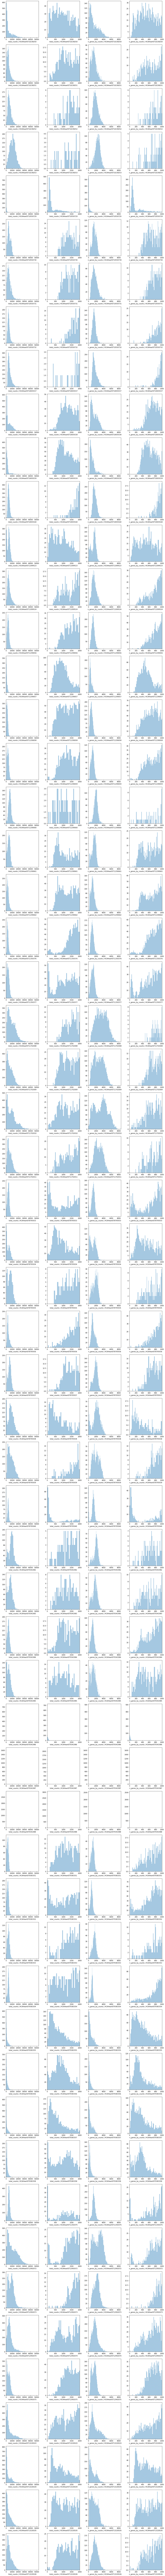

In [8]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata_vis.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata_vis, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata_vis.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<2000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 2000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<1000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 1000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

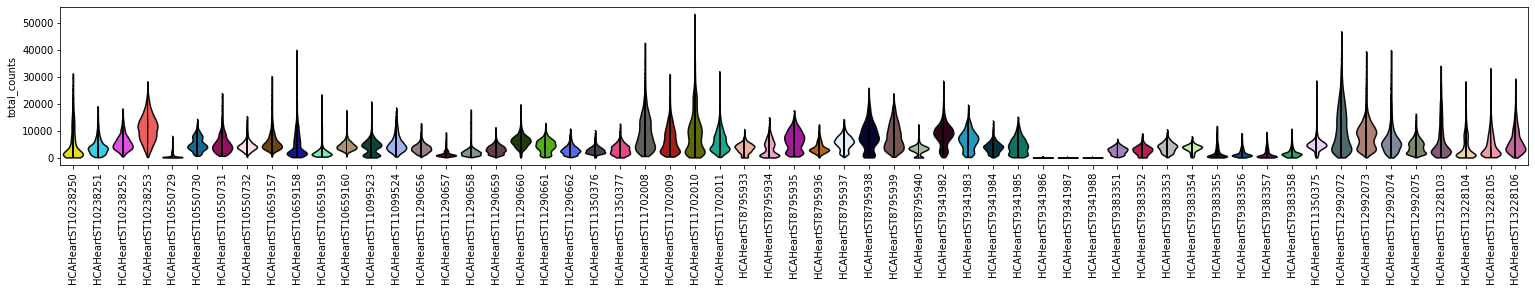

In [9]:
plt.rcParams['figure.figsize'] = 20,3
sc.pl.violin(adata_vis,keys=['total_counts'],groupby='sample',rotation=90,jitter=False)

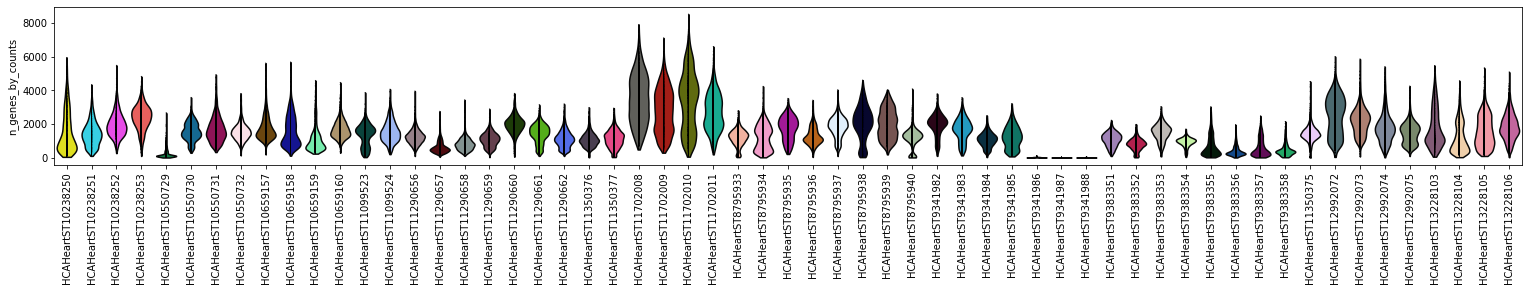

In [10]:
plt.rcParams['figure.figsize'] = 20,3
sc.pl.violin(adata_vis,keys=['n_genes_by_counts'],groupby='sample',rotation=90,jitter=False)

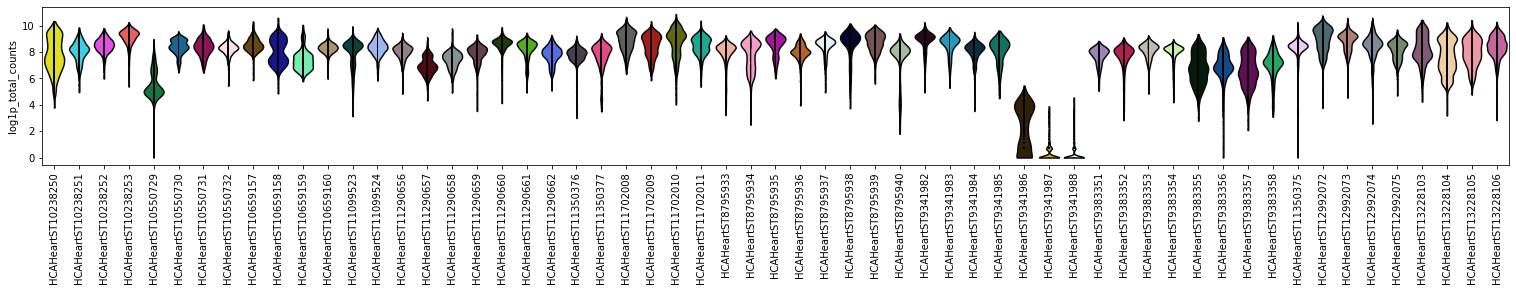

In [11]:
plt.rcParams['figure.figsize'] = 20,3
sc.pl.violin(adata_vis,keys=['log1p_total_counts'],groupby='sample',rotation=90,jitter=False)

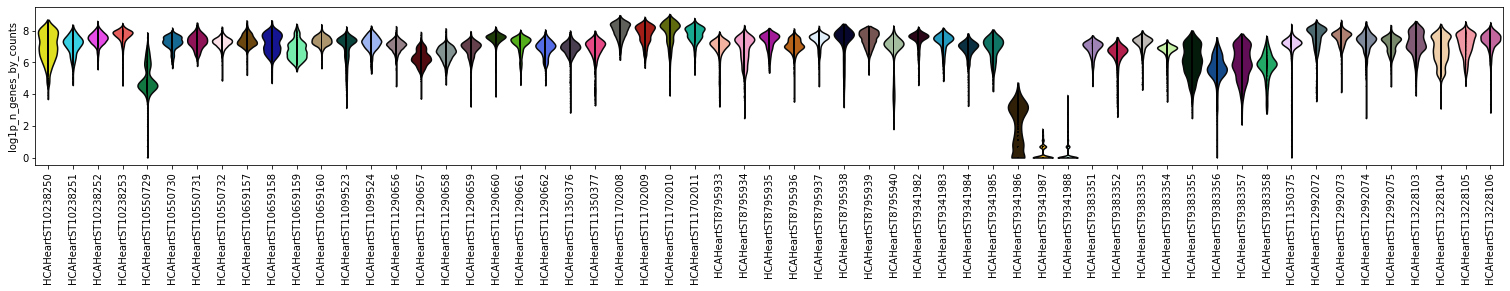

In [12]:
plt.rcParams['figure.figsize'] = 20,3
sc.pl.violin(adata_vis,keys=['log1p_n_genes_by_counts'],groupby='sample',rotation=90,jitter=False)

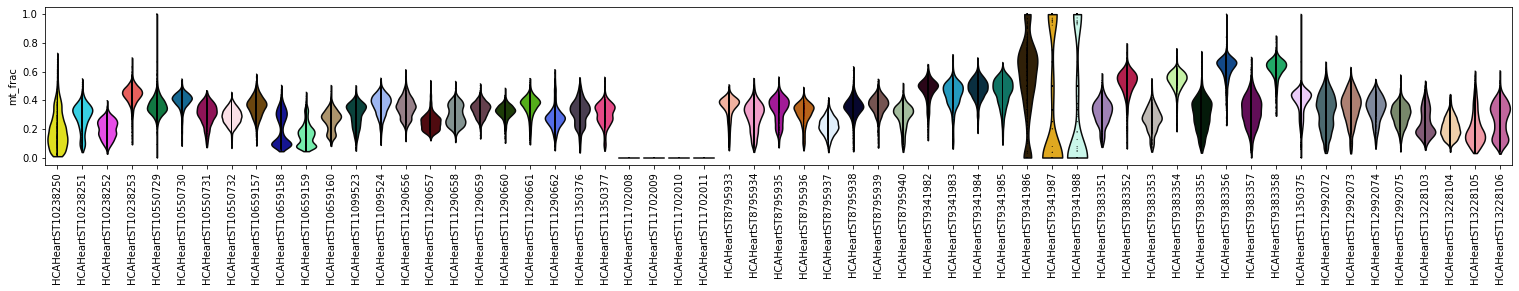

In [13]:
sc.pl.violin(adata_vis,keys=['mt_frac'],groupby='sample',rotation=90,jitter=False)

## Remove low quality slides

* 'HCAHeartST10550729','HCAHeartST9341986','HCAHeartST9341987','HCAHeartST9341988', has almost no counts -> remove

In [14]:
meta[meta['sangerID'].isin(['HCAHeartST10550729','HCAHeartST9341986','HCAHeartST9341987','HCAHeartST9341988',])]

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed
27,8regions,HCAHeartST10550729,na,D3,DBD,LV,LV,55-60,Male,Sanger,na,Visium,Visium-v1,no
43,8regions,HCAHeartST9341986,na,D7,DCD,RV,RV,60-65,Male,Sanger,na,Visium,Visium-v1,no
44,8regions,HCAHeartST9341987,na,D7,DCD,LA,LA,60-65,Male,Sanger,na,Visium,Visium-v1,no
45,8regions,HCAHeartST9341988,na,D7,DCD,SP,SP,60-65,Male,Sanger,na,Visium,Visium-v1,no


In [15]:
# remove
meta = meta[meta['sangerID'].isin(['HCAHeartST10550729','HCAHeartST9341986','HCAHeartST9341987','HCAHeartST9341988',])==False]

## Remove inappropriate slides for the publication '8regions'

* 'HCAHeartST10238250' has mostly large vessel but not the walls or SAN/AVN

In [16]:
meta[meta['sangerID']=='HCAHeartST10238250']

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed
4,8regions,HCAHeartST10238250,na,D8,DCD,LV,LV,45-50,Male,Sanger,na,Visium,Visium-v1,no


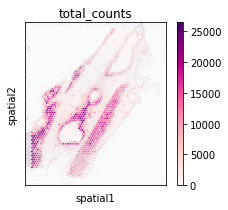

In [17]:
slide = select_slide(adata_vis, 'HCAHeartST10238250', s_col='sample')
genes = ['total_counts']
sc.pl.spatial(slide,cmap='RdPu',color=genes,ncols=5, wspace=0.05,use_raw=False,
              size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.8')

In [18]:
# remove
meta = meta[meta['sangerID'].isin(['HCAHeartST10238250',])==False]

## Remove replicated slides

In [19]:
meta[meta['sangerID'].isin(['HCAHeartST9341985','HCAHeartST9383351','HCAHeartST9383357'])]

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed
42,8regions,HCAHeartST9341985,na,D6,DCD,LA,LA,65-70,Male,Sanger,na,Visium,Visium-v1,no
46,8regions,HCAHeartST9383351,na,D6,DCD,RA,RA,65-70,Male,Sanger,na,Visium,Visium-v1,no
52,8regions,HCAHeartST9383357,na,D7,DCD,RA,RA,60-65,Male,Sanger,na,Visium,Visium-v1,no


In [20]:
# remove replicat slides (one of the 2 replicates)
meta=meta[meta['sangerID'].isin(['HCAHeartST9341985','HCAHeartST9383351','HCAHeartST9383357'])==False]

## Remove contaminated slide: HCAHeartST10550731

In [21]:
meta[meta['sangerID']=='HCAHeartST10550731']

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed
29,8regions,HCAHeartST10550731,na,D3,DBD,LA,LA,55-60,Male,Sanger,na,Visium,Visium-v1,no


In [22]:
# remove
meta = meta[meta['sangerID'].isin(['HCAHeartST10550731',])==False]

## Remove slides which don't have structure annotation

In [24]:
# path to directory which contains roi annotations csv files
path_to_annot='/nfs/team205/heart/visium_annotations/JC_annotations_csv'
category_name='annotation_JC'

# all annotation files
files=os.listdir(path_to_annot)
files_id=[x.split('_JC.csv')[0] for x in files]

In [25]:
# slides which dont have annotation
[x for x in meta['sangerID'] if x not in files_id]

[]

-> all slides have annotation

In [26]:
meta.shape

(50, 14)

## Save for cell2location analysis

In [27]:
meta.to_csv('/nfs/team205/heart/anndata_objects/8regions/metadata/HeartTeamSamples_Mappeddata_20221213_for-cell2loc.csv')

In [28]:
adata_vis

AnnData object with n_obs × n_vars = 154448 × 17922
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-HCAHeartST10238250', 'mean_counts-HCAHeartST10238250', 'log1p_mean_counts-HCAHeartST10238250', 'pct_dropout_by_counts-HCAHeartST10238250', 'total_counts-HCAHeartST10238250', 'log1p_total_counts-HCAHeartST10238250', 'n_cells_by_counts-HCAHeartST10238251', 'mean_counts-HCAHeartST10238251', 'log1p_mean_counts-HCAHeartST10238251', 'pct_dropout_by_counts-HCAHeartST10238251', 'total_counts-HCAHeartST10238251', 'log1p_total_counts-HCAHeartST10238251', 'n_cells_by_counts-HCAHeartST10238252', 'mean_counts-HCAHeartST10238252', 'log1p_mean_counts-HCAHeartST10238252', 'pct_dropout_by_counts-HCAHeartST1023